In [1]:
#This is the function to get the blue box position
def get_box_data(index, hdf5_data):
    """
    get `left, top, width, height` of each picture
    :param index:
    :param hdf5_data:
    :return:
    """
    meta_data = dict()
    meta_data['height'] = []
    meta_data['label'] = []
    meta_data['left'] = []
    meta_data['top'] = []
    meta_data['width'] = []

    def print_attrs(name, obj):
        vals = []
        if obj.shape[0] == 1:
            vals.append(obj[0][0])
        else:
            for k in range(obj.shape[0]):
                vals.append(int(hdf5_data[obj[k][0]][0][0]))
        meta_data[name] = vals

    box = hdf5_data['/digitStruct/bbox'][index]
    hdf5_data[box[0]].visititems(print_attrs)
    return meta_data

def get_name(index, hdf5_data):
    name = hdf5_data['/digitStruct/name']
    return ''.join([chr(v[0]) for v in hdf5_data[name[index][0]].value])

In [2]:
#This is to read the image from file into python
from scipy import misc
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

X_train=[]
directory="C:\\Users\\Mert Ketenci\\Desktop\\train\\train\\"
img_type=".png"
for i in range(1,500):
    image_name=[i,img_type]
    values = ''.join(str(v) for v in image_name)
    folder=[directory,values] 
    folder=''.join(folder)
    image = misc.imread(folder)
    X_train.append(image)


C:\Anaconda3\envs\dlenv\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  app.launch_new_instance()


In [38]:
# Run this cell will be able to provide you the cropped image in 54*54*3 format
import h5py
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2

mat_data = h5py.File('C:\\Users\\Mert Ketenci\\Desktop\\train\\train\\digitStruct.mat')
size = mat_data['/digitStruct/name'].size

#print (box)
label_Final = []
Pic_crop_Final = []
for i in range(499):
    Array = np.array(X_train[i])
    pic = get_name(i, mat_data)
    box = get_box_data(i, mat_data)
    label = box['label']
    label_Final.append(''.join(str(int(x%10)) for x in label))
 
    Test = label_Final[0]

    #Increase location by 30%
    
    H = int(round((max(box['top'])+max(box['height'])) *1.03))
    L = int(round (min(box['left']) *(0.97)))
    if L<0:
        L =0
    T = int(round (min(box['top'])*(0.97)))
    if T<0:
        T = 0
    W = int(round((max (box ['left'])+ max(box['width']))*1.03))

    Pic_crop = Array [T:H,L:W]


    #resize data and append
    res_Pic_crop = cv2.resize(Pic_crop, dsize=(54, 54), interpolation=cv2.INTER_CUBIC)
    Pic_crop_Final.append(res_Pic_crop)


[[[ 81  79  61]
  [ 90  73  58]
  [ 88  73  62]
  ...
  [ 89  79  71]
  [ 92  85  65]
  [ 81  82  57]]

 [[ 89  75  67]
  [ 90  73  64]
  [ 87  74  63]
  ...
  [ 81  78  65]
  [ 88  77  71]
  [ 89  77  66]]

 [[ 94  74  69]
  [ 85  79  64]
  [ 80  81  62]
  ...
  [ 88  87  63]
  [ 88  84  66]
  [ 87  84  62]]

 ...

 [[106 106  81]
  [107 106  88]
  [112 105  92]
  ...
  [111 100  89]
  [105 107  88]
  [108 105  82]]

 [[114 114  78]
  [111 110  76]
  [112 110  71]
  ...
  [106 101  89]
  [ 98 106  91]
  [106 104  90]]

 [[109 109  91]
  [107 105  98]
  [114 108  98]
  ...
  [102 105  88]
  [100 109  92]
  [105 107  93]]] 19


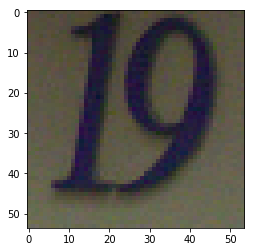

In [39]:
#Example of the reading output 
print(Pic_crop_Final[0],label_Final[0])
plt.imshow(Pic_crop_Final[0])

In [140]:
import tensorflow as tf
tf.reset_default_graph()


class Model(object):

    def inference(x, drop_rate):
        with tf.variable_scope('hidden1'):
            conv = tf.layers.conv2d(x, filters=48, kernel_size=[5, 5], padding='same')
            norm = tf.layers.batch_normalization(conv)
            activation = tf.nn.relu(norm)
            pool = tf.layers.max_pooling2d(activation, pool_size=[2, 2], strides=2, padding='same')
            hidden1 = pool  # 27 * 27 * 48
            # print(hidden1.shape)

        with tf.variable_scope('hidden2'):
            conv = tf.layers.conv2d(hidden1, filters=64, kernel_size=[5, 5], padding='same')
            norm = tf.layers.batch_normalization(conv)
            activation = tf.nn.relu(norm)
            pool = tf.layers.max_pooling2d(activation, pool_size=[2, 2], strides=1, padding='same')
            hidden2 = pool  # 27 * 27 * 64
            # print(hidden2.shape)

        with tf.variable_scope('hidden3'):
            conv = tf.layers.conv2d(hidden2, filters=128, kernel_size=[5, 5], padding='same')
            norm = tf.layers.batch_normalization(conv)
            activation = tf.nn.relu(norm)
            pool = tf.layers.max_pooling2d(activation, pool_size=[2, 2], strides=2, padding='same')
            hidden3 = pool  # 14 * 14 * 128
            # print(hidden3.shape)

        with tf.variable_scope('hidden4'):
            conv = tf.layers.conv2d(hidden3, filters=160, kernel_size=[5, 5], padding='same')
            norm = tf.layers.batch_normalization(conv)
            activation = tf.nn.relu(norm)
            pool = tf.layers.max_pooling2d(activation, pool_size=[2, 2], strides=1, padding='same')
            hidden4 = pool  # 14 * 14 *160
            # print(hidden4.shape)

        with tf.variable_scope('hidden5'):
            conv = tf.layers.conv2d(hidden4, filters=192, kernel_size=[5, 5], padding='same')
            norm = tf.layers.batch_normalization(conv)
            activation = tf.nn.relu(norm)
            pool = tf.layers.max_pooling2d(activation, pool_size=[2, 2], strides=2, padding='same')
            hidden5 = pool  # 7 * 7 * 192
            # print(hidden5.shape)

        with tf.variable_scope('hidden6'):
            conv = tf.layers.conv2d(hidden5, filters=192, kernel_size=[5, 5], padding='same')
            norm = tf.layers.batch_normalization(conv)
            activation = tf.nn.relu(norm)
            pool = tf.layers.max_pooling2d(activation, pool_size=[2, 2], strides=1, padding='same')
            hidden6 = pool  # 7 * 7 * 192
            # print(hidden6.shape)

        with tf.variable_scope('hidden7'):
            conv = tf.layers.conv2d(hidden6, filters=192, kernel_size=[5, 5], padding='same')
            norm = tf.layers.batch_normalization(conv)
            activation = tf.nn.relu(norm)
            pool = tf.layers.max_pooling2d(activation, pool_size=[2, 2], strides=2, padding='same')
            hidden7 = pool  # 4 * 4 * 192
            # print(hidden7.shape)

        with tf.variable_scope('hidden8'):
            conv = tf.layers.conv2d(hidden7, filters=192, kernel_size=[5, 5], padding='same')
            norm = tf.layers.batch_normalization(conv)
            activation = tf.nn.relu(norm)
            pool = tf.layers.max_pooling2d(activation, pool_size=[2, 2], strides=1, padding='same')
            hidden8 = pool  # 4 * 4 * 192

        flatten = tf.reshape(hidden8, [-1, 4 * 4 * 192])

        with tf.variable_scope('hidden9'):
            dense = tf.layers.dense(flatten, units=3072, activation=tf.nn.relu)
            dropout = tf.layers.dropout(dense, rate=drop_rate)
            hidden9 = dropout

        with tf.variable_scope('hidden10'):
            dense = tf.layers.dense(hidden9, units=3072, activation=tf.nn.relu)
            dropout = tf.layers.dropout(dense, rate=drop_rate)
            hidden10 = dropout

        with tf.variable_scope('digit_length'):
            dense = tf.layers.dense(hidden10, units=7)
            length = dense

        with tf.variable_scope('digit1'):
            dense = tf.layers.dense(hidden10, units=11)
            digit1 = dense

        with tf.variable_scope('digit2'):
            dense = tf.layers.dense(hidden10, units=11)
            digit2 = dense

        with tf.variable_scope('digit3'):
            dense = tf.layers.dense(hidden10, units=11)
            digit3 = dense

        with tf.variable_scope('digit4'):
            dense = tf.layers.dense(hidden10, units=11)
            digit4 = dense

        with tf.variable_scope('digit5'):
            dense = tf.layers.dense(hidden10, units=11)
            digit5 = dense

        length_logits, digits_logits = length, tf.stack([digit1, digit2, digit3, digit4, digit5], axis=1)

    def loss(length_logits, digits_logits, length_labels, digits_labels):
        # length_labels = tf.one_hot(length_labels, 7)
        # print(length_logits.shape, length_labels.shape)
        length_cross_entropy = tf.reduce_mean(
            tf.losses.sparse_softmax_cross_entropy(labels=length_labels, logits=length_logits))
        digit1_cross_entropy = tf.reduce_mean(
            tf.losses.sparse_softmax_cross_entropy(labels=digits_labels[:, 0], logits=digits_logits[:, 0, :]))
        digit2_cross_entropy = tf.reduce_mean(
            tf.losses.sparse_softmax_cross_entropy(labels=digits_labels[:, 1], logits=digits_logits[:, 1, :]))
        digit3_cross_entropy = tf.reduce_mean(
            tf.losses.sparse_softmax_cross_entropy(labels=digits_labels[:, 2], logits=digits_logits[:, 2, :]))
        digit4_cross_entropy = tf.reduce_mean(
            tf.losses.sparse_softmax_cross_entropy(labels=digits_labels[:, 3], logits=digits_logits[:, 3, :]))
        digit5_cross_entropy = tf.reduce_mean(
            tf.losses.sparse_softmax_cross_entropy(labels=digits_labels[:, 4], logits=digits_logits[:, 4, :]))
        loss = length_cross_entropy + digit1_cross_entropy + digit2_cross_entropy + digit3_cross_entropy + digit4_cross_entropy + digit5_cross_entropy
        return loss

In [7]:
x_tf = tf.placeholder(tf.float32, shape=(None,54,54,3))
y_tf = tf.placeholder(tf.float32, shape=(None,))

In [8]:
length_logist, digits_logist = Model.inference(x_tf,0.5)

In [9]:
length_labels = tf.placeholder(tf.int64, shape=(None,))

In [56]:
digits_labels = tf.placeholder(tf.int64, shape=(None,None,))

In [133]:
Pic_crop_Final = np.asarray(Pic_crop_Final).reshape(499,54,54,3)

In [146]:
label=[]
length=[]
for i in range(len(label_Final)):
    label.append([int(x) for x in label_Final[i]])
    length.append(len(label[-1])) 
for i in range(len(label)):   
    for j in range(5-len(label[i])):
        label[i].append(0)

In [126]:
thats_hot=[]
for i in range(len(label)):   
    hot = np.zeros((len(label[0]),10), dtype=int)
    hot[np.arange(len(label[0])), label[0]] = 1
    hot=np.transpose(hot)
    thats_hot.append(hot)
thats_hot=np.asarray(thats_hot)
thats_hot=thats_hot.reshape(thats_hot.shape[0]*thats_hot.shape[1],thats_hot.shape[2])

hot_length = np.zeros((len(length), 7),dtype=int)
hot_length[np.arange(len(length),), length] = 1

In [57]:
loss = Model.loss(length_logits=length_logist,digits_logits=digits_logist,
                  length_labels=length_labels,digits_labels=digits_labels) 

In [184]:
tf.reset_default_graph()


x = tf.placeholder(tf.float32, shape=(None,54,54,3))
length_labels = tf.placeholder(tf.int64, shape=(None,None,))
digits_labels =  tf.placeholder(tf.int64, shape=(None,None,None))
drop_rate=0.5

with tf.variable_scope('hidden1'):
    conv = tf.layers.conv2d(x, filters=48, kernel_size=[5, 5], padding='same')
    norm = tf.layers.batch_normalization(conv)
    activation = tf.nn.relu(norm)
    pool = tf.layers.max_pooling2d(activation, pool_size=[2, 2], strides=2, padding='same')
    hidden1 = pool  # 27 * 27 * 48
    # print(hidden1.shape)

with tf.variable_scope('hidden2'):
    conv = tf.layers.conv2d(hidden1, filters=64, kernel_size=[5, 5], padding='same')
    norm = tf.layers.batch_normalization(conv)
    activation = tf.nn.relu(norm)
    pool = tf.layers.max_pooling2d(activation, pool_size=[2, 2], strides=1, padding='same')
    hidden2 = pool  # 27 * 27 * 64
    # print(hidden2.shape)

with tf.variable_scope('hidden3'):
    conv = tf.layers.conv2d(hidden2, filters=128, kernel_size=[5, 5], padding='same')
    norm = tf.layers.batch_normalization(conv)
    activation = tf.nn.relu(norm)
    pool = tf.layers.max_pooling2d(activation, pool_size=[2, 2], strides=2, padding='same')
    hidden3 = pool  # 14 * 14 * 128
    # print(hidden3.shape)

with tf.variable_scope('hidden4'):
    conv = tf.layers.conv2d(hidden3, filters=160, kernel_size=[5, 5], padding='same')
    norm = tf.layers.batch_normalization(conv)
    activation = tf.nn.relu(norm)
    pool = tf.layers.max_pooling2d(activation, pool_size=[2, 2], strides=1, padding='same')
    hidden4 = pool  # 14 * 14 *160
    # print(hidden4.shape)

with tf.variable_scope('hidden5'):
    conv = tf.layers.conv2d(hidden4, filters=192, kernel_size=[5, 5], padding='same')
    norm = tf.layers.batch_normalization(conv)
    activation = tf.nn.relu(norm)
    pool = tf.layers.max_pooling2d(activation, pool_size=[2, 2], strides=2, padding='same')
    hidden5 = pool  # 7 * 7 * 192
    # print(hidden5.shape)

with tf.variable_scope('hidden6'):
    conv = tf.layers.conv2d(hidden5, filters=192, kernel_size=[5, 5], padding='same')
    norm = tf.layers.batch_normalization(conv)
    activation = tf.nn.relu(norm)
    pool = tf.layers.max_pooling2d(activation, pool_size=[2, 2], strides=1, padding='same')
    hidden6 = pool  # 7 * 7 * 192
    # print(hidden6.shape)

with tf.variable_scope('hidden7'):
    conv = tf.layers.conv2d(hidden6, filters=192, kernel_size=[5, 5], padding='same')
    norm = tf.layers.batch_normalization(conv)
    activation = tf.nn.relu(norm)
    pool = tf.layers.max_pooling2d(activation, pool_size=[2, 2], strides=2, padding='same')
    hidden7 = pool  # 4 * 4 * 192
    # print(hidden7.shape)

with tf.variable_scope('hidden8'):
    conv = tf.layers.conv2d(hidden7, filters=192, kernel_size=[5, 5], padding='same')
    norm = tf.layers.batch_normalization(conv)
    activation = tf.nn.relu(norm)
    pool = tf.layers.max_pooling2d(activation, pool_size=[2, 2], strides=1, padding='same')
    hidden8 = pool  # 4 * 4 * 192

flatten = tf.reshape(hidden8, [-1, 4 * 4 * 192])

with tf.variable_scope('hidden9'):
    dense = tf.layers.dense(flatten, units=3072, activation=tf.nn.relu)
    dropout = tf.layers.dropout(dense, rate=drop_rate)
    hidden9 = dropout

with tf.variable_scope('hidden10'):
    dense = tf.layers.dense(hidden9, units=3072, activation=tf.nn.relu)
    dropout = tf.layers.dropout(dense, rate=drop_rate)
    hidden10 = dropout

with tf.variable_scope('digit_length'):
    dense = tf.layers.dense(hidden10, units=7)
    length = dense

with tf.variable_scope('digit1'):
    dense = tf.layers.dense(hidden10, units=10)
    digit1 = dense

with tf.variable_scope('digit2'):
    dense = tf.layers.dense(hidden10, units=10)
    digit2 = dense

with tf.variable_scope('digit3'):
    dense = tf.layers.dense(hidden10, units=10)
    digit3 = dense

with tf.variable_scope('digit4'):
    dense = tf.layers.dense(hidden10, units=10)
    digit4 = dense

with tf.variable_scope('digit5'):
    dense = tf.layers.dense(hidden10, units=10)
    digit5 = dense

length_logits, digits_logits = length, tf.stack([digit1, digit2, digit3, digit4, digit5], axis=1)

# length_labels = tf.one_hot(length_labels, 7)
# print(length_logits.shape, length_labels.shape)
length_cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits (labels=length_labels, logits=length_logits))
digit1_cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits (labels=digits_labels[:, 0], logits=digits_logits[:, 0, :]))
digit2_cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits (labels=digits_labels[:, 1], logits=digits_logits[:, 1, :]))
digit3_cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits (labels=digits_labels[:, 2], logits=digits_logits[:, 2, :]))
digit4_cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits (labels=digits_labels[:, 3], logits=digits_logits[:, 3, :]))
digit5_cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits (labels=digits_labels[:, 4], logits=digits_logits[:, 4, :]))
loss = length_cross_entropy + digit1_cross_entropy + digit2_cross_entropy + digit3_cross_entropy + digit4_cross_entropy + digit5_cross_entropy


init = tf.global_variables_initializer()
train_step = tf.train.GradientDescentOptimizer(1e-6).minimize(loss)



num_train = 499
batch_size = 32
num_batch = num_train//batch_size

with tf.Session() as sess:
    sess.run(init)
    for e in range(20):
        for i in range(num_batch):
            batch_x, batch_digits, batch_length = Pic_crop_Final[i*batch_size:(i+1)*batch_size], thats_hot1[i*batch_size:(i+1)*batch_size], hot_length[i*batch_size:(i+1)*batch_size]
            sess.run(train_step, feed_dict={x:batch_x , length_labels:batch_length ,digits_labels:batch_digits})
            loss_tf = sess.run(loss, feed_dict={x:Pic_crop_Final , length_labels:hot_length ,digits_labels:thats_hot1})
            print(loss_tf)

27.23064
26.527454
25.900303
25.196466
24.63354
24.04755
23.451832
22.829802
22.28241
21.77157
21.290165
20.784594
20.345816
19.922583
19.519941
19.09723
18.70294
18.35188
17.953478
17.63319
17.30639
16.969902
16.623404
16.314693
16.027967
15.762004
15.482707
15.236642
15.001706
14.77519
14.544662
14.32538
14.130543
13.913472
13.738562
13.556849
13.374232
13.185695
13.015989
12.856112
12.70831
12.552696
12.414827
12.283007
12.155164
12.02463
11.900024
11.786947
11.661989
11.559004
11.452181
11.344026
11.232134
11.130134
11.0342045
10.942995
10.849855
10.765314
10.684158
10.605447
10.5246315
10.446694
10.375698
10.297733
10.232954
10.164795
10.095548
10.023288
9.957071
9.894718
9.83487
9.773467
9.717409
9.66278
9.611495
9.557265
9.504326
9.457102
9.405041
9.3608
9.313764
9.26583
9.215839
9.170265
9.127236
9.086259
9.04411
9.004247
8.965826
8.92996
8.891947
8.8544
8.821544
8.784245
8.75313
8.718428
8.683937
8.647462
8.614167
8.582949
8.553192
8.521921
8.493562
8.465089
8.439027
8.411529


In [174]:
a=Pic_crop_Final[i*batch_size:(i+1)*batch_size]

In [175]:
a.shape

(10, 54, 54, 3)